# Credit Card Fraud Detection Baseline Model

# Importing libraries

In [203]:
# munging imports
import pandas as pd
import numpy as np
import datetime

# visualization imports
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# Logistic regression visualization utility function
def generate_logreg_vis(beta=-.05):
    
    # draw feature values and use beta to calculate predicted probability
    # of positive class for each feature value
    x = np.random.uniform(low=-1, high=1, size=150) * 100
    p = 1 / (1 + np.exp(-(beta*x))) # logistic regression function
    
    # plot predicted probs against the feature 
    plt.scatter(x, p)
    plt.title('Probability of Default vs. Credit Rating Score')
    plt.ylabel('Predicted Probability of Default')
    plt.xlabel('Credit Rating Score')
    
    # 50% probability threshold
    plt.gca().axhline(.5,c='k',ls='--',lw=1)

# Importing data

In [204]:
df = pd.read_csv("C:/Users/New User/Desktop/Fraud/data/fraudTrain.csv")
df = df.drop('Unnamed: 0', 1) #dropping unncessary columns
sample_df = df.sample(n=10000) #taking 10,000 samples from original data of over 1m rows
sample_df.info()

C:\Users\NEWUSE~1\AppData\Local\Temp/ipykernel_20848/2990681922.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('Unnamed: 0', 1) #dropping unncessary columns


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1179553 to 794190
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  10000 non-null  object 
 1   cc_num                 10000 non-null  int64  
 2   merchant               10000 non-null  object 
 3   category               10000 non-null  object 
 4   amt                    10000 non-null  float64
 5   first                  10000 non-null  object 
 6   last                   10000 non-null  object 
 7   gender                 10000 non-null  object 
 8   street                 10000 non-null  object 
 9   city                   10000 non-null  object 
 10  state                  10000 non-null  object 
 11  zip                    10000 non-null  int64  
 12  lat                    10000 non-null  float64
 13  long                   10000 non-null  float64
 14  city_pop               10000 non-null  int64  


# EDA

Class Distribution:
 0    9952
1      48
Name: is_fraud, dtype: int64


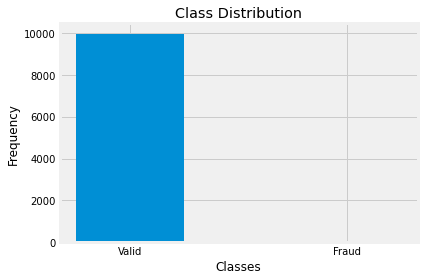

In [205]:
#Class Distribution
import numpy as np
import matplotlib.pyplot as plt
plt.bar([0,1], sample_df['is_fraud'].value_counts(), width=0.5, bottom=None, align='center', data=sample_df)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Valid', 'Fraud'])
print('Class Distribution:\n',sample_df['is_fraud'].value_counts())
plt.tight_layout()
plt.savefig('C:/Users/New User/Desktop/Fraud/class_distribution.png')

In [188]:
# fraud rate of sample or the average of sample that is fraud
average = df['is_fraud'].mean()
average

0.0052

In [189]:
# correlation matrix with numeric values
# features with strongest correlation: amt
df.corr()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
cc_num,1.000000,-0.003963,0.052588,-0.038133,-0.051962,-0.028030,-0.008089,-0.039288,-0.052076,0.015541
amt,-0.003963,1.000000,-0.015969,-0.021180,0.018693,0.005838,-0.010742,-0.020428,0.019483,0.230721
zip,0.052588,-0.015969,1.000000,-0.133386,-0.908784,0.048198,-0.005012,-0.133616,-0.907797,-0.002544
lat,-0.038133,-0.021180,-0.133386,1.000000,0.003528,-0.127709,0.000425,0.993519,0.004520,0.003988
long,-0.051962,0.018693,-0.908784,0.003528,1.000000,-0.027843,-0.000183,0.003820,0.999076,0.004558
city_pop,-0.028030,0.005838,0.048198,-0.127709,-0.027843,1.000000,-0.002182,-0.126755,-0.028480,-0.002292
unix_time,-0.008089,-0.010742,-0.005012,0.000425,-0.000183,-0.002182,1.000000,0.000778,-0.000433,-0.010212
merch_lat,-0.039288,-0.020428,-0.133616,0.993519,0.003820,-0.126755,0.000778,1.000000,0.004738,0.005364
merch_long,-0.052076,0.019483,-0.907797,0.004520,0.999076,-0.028480,-0.000433,0.004738,1.000000,0.005630
is_fraud,0.015541,0.230721,-0.002544,0.003988,0.004558,-0.002292,-0.010212,0.005364,0.005630,1.000000


<AxesSubplot:>

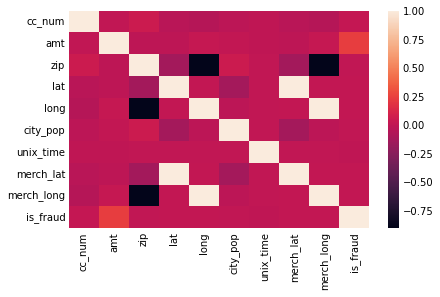

In [190]:
# correlation matrix with heatmap
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

 # Training and Testing

In [206]:
# CONVERTING DATETIME STRING TO DATETIME

current_date = datetime.datetime.now()

print("Original date and time object:", current_date)


sample_df['trans_date_trans_time'] = int(current_date.strftime("%Y%m%d%H%M%S"))

Original date and time object: 2022-02-21 19:12:01.076775


In [207]:
sample_df['dob']= pd.to_datetime(sample_df['dob'], format='%Y-%m-%d')

In [208]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1179553 to 794190
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trans_date_trans_time  10000 non-null  int64         
 1   cc_num                 10000 non-null  int64         
 2   merchant               10000 non-null  object        
 3   category               10000 non-null  object        
 4   amt                    10000 non-null  float64       
 5   first                  10000 non-null  object        
 6   last                   10000 non-null  object        
 7   gender                 10000 non-null  object        
 8   street                 10000 non-null  object        
 9   city                   10000 non-null  object        
 10  state                  10000 non-null  object        
 11  zip                    10000 non-null  int64         
 12  lat                    10000 non-null  float64       

In [209]:
# splitting features into X and target into y
X = sample_df[['trans_date_trans_time', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']]
y = sample_df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)


In [210]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X=sc.fit_transform(X)

# Logistic Regression CV

In [211]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=10, random_state=42,class_weight='balanced',max_iter=1000).fit(X_train, y_train)

In [212]:
predictions1=clf.predict(X_test)

In [213]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions1))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1994
           1       0.00      0.00      0.00         6

    accuracy                           0.91      2000
   macro avg       0.50      0.46      0.48      2000
weighted avg       0.99      0.91      0.95      2000



In [216]:
y_score = clf.decision_function(X_test)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
from sklearn.metrics import roc_auc_score
y_pred_prob = clf.predict_proba(X_test)
print('Average ROC_AUC score: {0:0.2f}'.format(roc_auc_score(y_test, y_pred_prob[:,1])))

Average precision-recall score: 0.00
Average ROC_AUC score: 0.54


In [220]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


Confusion Matrix:  [[1823  171]
 [   6    0]]


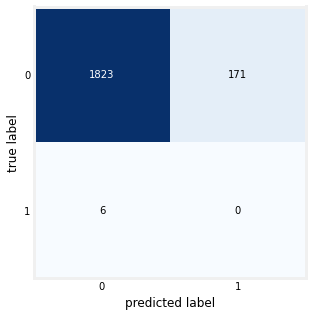

<Figure size 432x288 with 0 Axes>

In [222]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, predictions1)
print('Confusion Matrix: ',CM)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()
plt.savefig('C:/Users/New User/Desktop/Fraud/confusion_matrix.png')

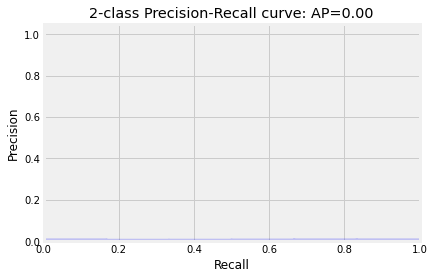

In [218]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.savefig('C:/Users/New User/Desktop/Fraud/precision-recall-curve.png')

In [171]:
# def curves():
        
#     plt.clf()
#     plt.cla()
#     plt.close()
    
#     lr = LogisticRegression().fit(X_train, y_train)
#     y_score = lr.decision_function(X_test)
#     precision, recall, thresholds = precision_recall_curve(y_test, y_score)
#     plt.figure(figsize=(10,10))
#     plt.xlim([0.0, 1.01])
#     plt.ylim([0.0, 1.01])
#     plt.plot(precision, recall, label='Precision-Recall Curve')
#     plt.xlabel('Precision', labelpad=15, fontsize = 12)
#     plt.ylabel('Recall', labelpad=10, fontsize = 12)
#     plt.title('Credit card fraud data analysis\nPrecision-Recall Curve\n', fontsize = 18, fontname = 'Comic Sans MS', fontweight = 'bold', alpha=1)
#     plt.axes().set_aspect('equal')
#     pylab.savefig('C:/Users/New User/Desktop/Fraud/precision_recall.png')
#     plt.show()
#     prec_rec = pd.DataFrame({'precision': precision, 'recall': recall})
#     rcl = prec_rec['recall'][prec_rec.precision >= .079]
#     #print('recall = ', rcl.iloc[0:10])
    
#     fpr, tpr, _ = roc_curve(y_test, y_score)
#     roc_auc = auc(fpr, tpr)
#     plt.figure(figsize=(10,10))
#     plt.xlim([-0.01, 1.00])
#     plt.ylim([-0.01, 1.01])
#     plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc))
#     plt.xlabel('False Positive Rate', labelpad=15, fontsize = 12)
#     plt.ylabel('True Positive Rate', labelpad=10, fontsize = 12)
#     plt.title('Credit card fraud data analysis\nROC curve\n', fontsize = 18, fontname = 'Comic Sans MS', fontweight = 'bold', alpha=1)
#     plt.legend(loc='lower right', fontsize=12)
#     plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
#     plt.axes().set_aspect('equal')
#     pylab.savefig('C:/Users/New User/Desktop/Fraud/roc.png')
#     plt.show()
#     roc = pd.DataFrame({'tpr': tpr, 'fpr': fpr})
#     tr_pos_r = roc['tpr'][roc.fpr >= 0.16]
#     #print('tpr = ', tr_pos_r.iloc[0:10])
        
#     return (rcl.iloc[0], tr_pos_r.iloc[0])

In [83]:
# target vs feature pairplotting - HELP
# sns.pairplot(sample_df, hue='is_fraud');

In [84]:
# target vs feature boxplot - HELP

In [ ]:
# LOGISTIC REGRESSION USING ACCURACY AS METRIC

In [105]:
lm1 = LogisticRegression(C=1000) # setting C very high essentially removes regularization
lm1.fit(X_train[['amt']], y_train)
lm1.score(X_train[['amt']], y_train)

0.995

In [87]:
# DECISION BOUNDARY

In [106]:
# creating train_df
train_df = X_train.copy()
train_df['is_fraud'] = y_train
train_df.head()

,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
1284906,20220221170021,4198470814557,3.85,51521,41.4768,-95.3509,2036,1371392415,42.390806,-94.790320,0
12158,20220221170021,3591919803438423,77.20,32780,28.5697,-80.8191,54767,1325983230,29.375366,-80.586918,0
75506,20220221170021,3504178999463051,55.53,45801,40.7641,-84.0973,86954,1329180476,40.873303,-84.159708,0
149939,20220221170021,4010002218955876,226.05,77026,29.7972,-95.3288,2906700,1332385610,29.797038,-94.724374,0
219128,20220221170021,4997733566924489,103.03,55128,44.9913,-92.9487,753116,1335013993,44.330079,-92.388316,0


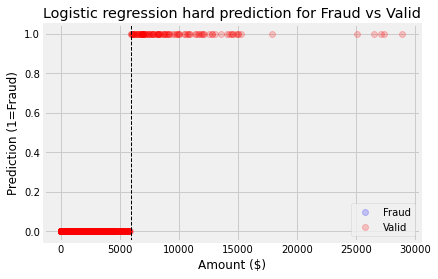

In [117]:
def viz_SF_LR(sample_df, model, hard_classification=True, decision_boundary=False):

    # extract amt feature and hard or soft predictions
    feature = df[['amt']]
    if hard_classification:
        predictions = model.predict(feature)
    else:
        predictions = model.predict_proba(feature)[:, 1] 

    # color filter true class labels and plot predictions
    sf_mask = (df['is_fraud'] == 1).values
    plt.plot(feature[sf_mask], predictions[sf_mask], 'bo', label='Fraud', alpha=0.2)
    plt.plot(feature[~sf_mask], predictions[~sf_mask], 'ro', label='Valid', alpha=0.2)
    
    # optionally calculate and display decision boundary as dotted line
    if decision_boundary:
        b_0, b_1 = model.intercept_, model.coef_[0]
        plt.gca().axvline(-b_0/b_1,c='k',ls='--',lw=1)
    
    # plot formatting
    plt.ylim(-0.05, 1.05)
    plt.xlabel('Amount ($)')
    plt.ylabel('Prediction (1=Fraud)')
    type_str = 'hard' if hard_classification else 'soft'
    plt.title('Logistic regression ' + type_str + ' prediction for Fraud vs Valid')
    plt.legend(loc='lower right')
    
viz_SF_LR(train_df, lm1, decision_boundary=True)

# Classification Evaluation Metrics

In [113]:
def accuracy(actuals, preds):
    return (np.mean(actuals == preds))

def precision(actuals, preds):
    tp = np.sum((actuals == 1) & (preds == 1))
    fp = np.sum((actuals == 0) & (preds == 1))
    return (tp / (tp + fp))

def recall(actuals, preds):
    tp = np.sum((actuals == 1) & (preds == 1))
    fn = np.sum((actuals == 1) & (preds == 0))
    return (tp / (tp + fn))

def F1(actuals, preds):
    p, r = precision(actuals, preds), recall(actuals, preds)
    return (2*p*r / (p + r))

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

lr = LogisticRegression(C = 1000) #large C means no regularization, confusing! (inverse regularization strength)
knn = KNeighborsClassifier(n_neighbors = 10)

lr.fit(X_train, y_train)
knn.fit(X_train, y_train)

C:\Users\New User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KNeighborsClassifier(n_neighbors=10)

# Score models on test set

In [115]:
print('Logistic regression validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, lr.predict(X_test)), 
         precision(y_test, lr.predict(X_test)), 
         recall(y_test, lr.predict(X_test)),
         F1(y_test, lr.predict(X_test))
        )
     )

print('\n')

print('10 nearest neighbors validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, knn.predict(X_test)), 
         precision(y_test, knn.predict(X_test)), 
         recall(y_test, knn.predict(X_test)),
         F1(y_test, knn.predict(X_test))
        )
     )

C:\Users\NEWUSE~1\AppData\Local\Temp/ipykernel_20848/1525214215.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  return (tp / (tp + fp))
C:\Users\NEWUSE~1\AppData\Local\Temp/ipykernel_20848/1525214215.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  return (tp / (tp + fp))
C:\Users\NEWUSE~1\AppData\Local\Temp/ipykernel_20848/1525214215.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  return (tp / (tp + fp))


Logistic regression validation metrics: 
 Accuracy: 0.9955 
 Precision: nan 
 Recall: 0.0000 
 F1: nan


10 nearest neighbors validation metrics: 
 Accuracy: 0.9955 
 Precision: nan 
 Recall: 0.0000 
 F1: nan


C:\Users\NEWUSE~1\AppData\Local\Temp/ipykernel_20848/1525214215.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  return (tp / (tp + fp))
